In [ ]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 11.8 MB/s eta 0:00:00


In [ ]:
!pip install colorthief
!pip install webcolors

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from scipy.io import savemat
import numpy as np
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import cv2
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
from colorthief import ColorThief
import webcolors
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

In [ ]:
if not (os.path.isfile('Indian_pines_corrected.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
if not (os.path.isfile('Indian_pines_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat



# Data Loading

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

In [ ]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']

    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [ ]:
K = X.shape[2]

In [ ]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
#print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                                                                 
 flatten (Flatten)           (None, 18496)             0     

In [ ]:
# compiling the model
adam = Adam(learning_rate=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 2.7487 - accuracy: 0.1467

13/13 [==============================] - 14s 207ms/step - loss: 2.7487 - accuracy: 0.1467
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 2.4492 - accuracy: 0.2041

13/13 [==============================] - 3s 192ms/step - loss: 2.4497 - accuracy: 0.2040
Epoch 3/100
12/13 [==========================>...] - ETA: 0s - loss: 2.2566 - accuracy: 0.2591

13/13 [==============================] - 2s 191ms/step - loss: 2.2562 - accuracy: 0.2593
Epoch 4/100
12/13 [==========================>...] - ETA: 0s - loss: 1.8967 - accuracy: 0.3581

13/13 [==============================] - 2s 191ms/step - loss: 1.8967 - accuracy: 0.3578
Epoch 5/100
12/13 [==========================>...] - ETA: 0s - loss: 1.4600 - accuracy: 0.4961

13/13 [==============================] - 3s 192ms/step - loss: 1.4592 - accuracy: 0.4964
Epoch 6/100
12/13 [==========================>...] - ETA: 0s - loss: 1.1382 - accuracy: 0.5885

13/13 [==============================] - 3s 196ms/step - loss: 1.1380 - accuracy: 0.5888
Epoch 7/100
12/13 [==========================>...] - ETA: 0s - loss: 0.9042 - accuracy: 0.6823

13/13 [==============================] - 3s 197ms/step - loss: 0.9039 - accuracy: 0.6822
Epoch 8/100
12/13 [==========================>...] - ETA: 0s - loss: 0.7143 - accuracy: 0.7565

13/13 [==============================] - 3s 194ms/step - loss: 0.7139 - accuracy: 0.7567
Epoch 9/100
12/13 [==========================>...] - ETA: 0s - loss: 0.4804 - accuracy: 0.8411

13/13 [==============================] - 3s 195ms/step - loss: 0.4801 - accuracy: 0.8412
Epoch 10/100
12/13 [==========================>...] - ETA: 0s - loss: 0.3086 - accuracy: 0.9053

13/13 [==============================] - 3s 195ms/step - loss: 0.3084 - accuracy: 0.9053
Epoch 11/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1986 - accuracy: 0.9310

13/13 [==============================] - 3s 205ms/step - loss: 0.1985 - accuracy: 0.9310
Epoch 12/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1582 - accuracy: 0.9495

13/13 [==============================] - 3s 203ms/step - loss: 0.1580 - accuracy: 0.9496
Epoch 13/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1435 - accuracy: 0.9502

13/13 [==============================] - 3s 197ms/step - loss: 0.1434 - accuracy: 0.9502
Epoch 14/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1074 - accuracy: 0.9655

13/13 [==============================] - 3s 198ms/step - loss: 0.1073 - accuracy: 0.9655
Epoch 15/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0884 - accuracy: 0.9740

13/13 [==============================] - 3s 199ms/step - loss: 0.0884 - accuracy: 0.9740
Epoch 16/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0750 - accuracy: 0.9805

13/13 [==============================] - 3s 201ms/step - loss: 0.0749 - accuracy: 0.9805
Epoch 17/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0608 - accuracy: 0.9831

13/13 [==============================] - 3s 204ms/step - loss: 0.0608 - accuracy: 0.9831
Epoch 18/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0508 - accuracy: 0.9854

13/13 [==============================] - 3s 201ms/step - loss: 0.0508 - accuracy: 0.9854
Epoch 19/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0590 - accuracy: 0.9847

13/13 [==============================] - 3s 201ms/step - loss: 0.0590 - accuracy: 0.9847
Epoch 20/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0575 - accuracy: 0.9824

13/13 [==============================] - 3s 201ms/step - loss: 0.0575 - accuracy: 0.9824
Epoch 21/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0520 - accuracy: 0.9860

13/13 [==============================] - 3s 203ms/step - loss: 0.0520 - accuracy: 0.9860
Epoch 22/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0396 - accuracy: 0.9896

13/13 [==============================] - 3s 207ms/step - loss: 0.0396 - accuracy: 0.9896
Epoch 23/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0306 - accuracy: 0.9899

13/13 [==============================] - 3s 205ms/step - loss: 0.0306 - accuracy: 0.9899
Epoch 24/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0251 - accuracy: 0.9935

13/13 [==============================] - 3s 204ms/step - loss: 0.0251 - accuracy: 0.9935
Epoch 25/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0243 - accuracy: 0.9928

13/13 [==============================] - 3s 205ms/step - loss: 0.0242 - accuracy: 0.9928
Epoch 26/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0270 - accuracy: 0.9919

13/13 [==============================] - 3s 206ms/step - loss: 0.0270 - accuracy: 0.9919
Epoch 27/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0234 - accuracy: 0.9925

13/13 [==============================] - 3s 206ms/step - loss: 0.0234 - accuracy: 0.9925
Epoch 28/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0134 - accuracy: 0.9961

13/13 [==============================] - 3s 204ms/step - loss: 0.0134 - accuracy: 0.9961
Epoch 29/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0211 - accuracy: 0.9938

13/13 [==============================] - 3s 203ms/step - loss: 0.0211 - accuracy: 0.9938
Epoch 30/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0233 - accuracy: 0.9954

13/13 [==============================] - 3s 202ms/step - loss: 0.0233 - accuracy: 0.9954
Epoch 31/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0181 - accuracy: 0.9938

13/13 [==============================] - 3s 203ms/step - loss: 0.0180 - accuracy: 0.9938
Epoch 32/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0168 - accuracy: 0.9938

13/13 [==============================] - 3s 206ms/step - loss: 0.0168 - accuracy: 0.9938
Epoch 33/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0235 - accuracy: 0.9915

13/13 [==============================] - 3s 202ms/step - loss: 0.0234 - accuracy: 0.9915
Epoch 34/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0319 - accuracy: 0.9938

13/13 [==============================] - 3s 201ms/step - loss: 0.0319 - accuracy: 0.9938
Epoch 35/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0284 - accuracy: 0.9915

13/13 [==============================] - 3s 201ms/step - loss: 0.0284 - accuracy: 0.9915
Epoch 36/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0231 - accuracy: 0.9932

13/13 [==============================] - 3s 201ms/step - loss: 0.0231 - accuracy: 0.9932
Epoch 37/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0152 - accuracy: 0.9964

13/13 [==============================] - 3s 203ms/step - loss: 0.0152 - accuracy: 0.9964
Epoch 38/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0158 - accuracy: 0.9948

13/13 [==============================] - 3s 201ms/step - loss: 0.0158 - accuracy: 0.9948
Epoch 39/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0305 - accuracy: 0.9899

13/13 [==============================] - 3s 199ms/step - loss: 0.0305 - accuracy: 0.9899
Epoch 40/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0207 - accuracy: 0.9941

13/13 [==============================] - 3s 199ms/step - loss: 0.0207 - accuracy: 0.9941
Epoch 41/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0098 - accuracy: 0.9971

13/13 [==============================] - 3s 200ms/step - loss: 0.0098 - accuracy: 0.9971
Epoch 42/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0209 - accuracy: 0.9938

13/13 [==============================] - 3s 204ms/step - loss: 0.0209 - accuracy: 0.9938
Epoch 43/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0193 - accuracy: 0.9941

13/13 [==============================] - 3s 200ms/step - loss: 0.0193 - accuracy: 0.9941
Epoch 44/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0121 - accuracy: 0.9977

13/13 [==============================] - 3s 200ms/step - loss: 0.0121 - accuracy: 0.9977
Epoch 45/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0188 - accuracy: 0.9951

13/13 [==============================] - 3s 200ms/step - loss: 0.0188 - accuracy: 0.9951
Epoch 46/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0254 - accuracy: 0.9915

13/13 [==============================] - 3s 199ms/step - loss: 0.0254 - accuracy: 0.9915
Epoch 47/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0323 - accuracy: 0.9912

13/13 [==============================] - 3s 204ms/step - loss: 0.0322 - accuracy: 0.9912
Epoch 48/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0267 - accuracy: 0.9919

13/13 [==============================] - 3s 202ms/step - loss: 0.0267 - accuracy: 0.9919
Epoch 49/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0298 - accuracy: 0.9906

13/13 [==============================] - 3s 200ms/step - loss: 0.0298 - accuracy: 0.9906
Epoch 50/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0197 - accuracy: 0.9958

13/13 [==============================] - 3s 201ms/step - loss: 0.0197 - accuracy: 0.9958
Epoch 51/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0199 - accuracy: 0.9958

13/13 [==============================] - 3s 201ms/step - loss: 0.0199 - accuracy: 0.9958
Epoch 52/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0164 - accuracy: 0.9958

13/13 [==============================] - 3s 203ms/step - loss: 0.0164 - accuracy: 0.9958
Epoch 53/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0127 - accuracy: 0.9967

13/13 [==============================] - 3s 202ms/step - loss: 0.0126 - accuracy: 0.9967
Epoch 54/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0083 - accuracy: 0.9971

13/13 [==============================] - 3s 201ms/step - loss: 0.0083 - accuracy: 0.9971
Epoch 55/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0107 - accuracy: 0.9971

13/13 [==============================] - 3s 202ms/step - loss: 0.0107 - accuracy: 0.9971
Epoch 56/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0117 - accuracy: 0.9971

13/13 [==============================] - 3s 201ms/step - loss: 0.0117 - accuracy: 0.9971
Epoch 57/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0100 - accuracy: 0.9961

13/13 [==============================] - 3s 204ms/step - loss: 0.0100 - accuracy: 0.9961
Epoch 58/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0110 - accuracy: 0.9958

13/13 [==============================] - 3s 204ms/step - loss: 0.0110 - accuracy: 0.9958
Epoch 59/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0072 - accuracy: 0.9980

13/13 [==============================] - 3s 202ms/step - loss: 0.0072 - accuracy: 0.9980
Epoch 60/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0081 - accuracy: 0.9980

13/13 [==============================] - 3s 202ms/step - loss: 0.0081 - accuracy: 0.9980
Epoch 61/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0111 - accuracy: 0.9967

13/13 [==============================] - 3s 201ms/step - loss: 0.0111 - accuracy: 0.9967
Epoch 62/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0110 - accuracy: 0.9958

13/13 [==============================] - 3s 206ms/step - loss: 0.0110 - accuracy: 0.9958
Epoch 63/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0064 - accuracy: 0.9984

13/13 [==============================] - 3s 203ms/step - loss: 0.0064 - accuracy: 0.9984
Epoch 64/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0093 - accuracy: 0.9980

13/13 [==============================] - 3s 201ms/step - loss: 0.0093 - accuracy: 0.9980
Epoch 65/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0040 - accuracy: 0.9993

13/13 [==============================] - 3s 201ms/step - loss: 0.0040 - accuracy: 0.9993
Epoch 66/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0056 - accuracy: 0.9980

13/13 [==============================] - 3s 201ms/step - loss: 0.0056 - accuracy: 0.9980
Epoch 67/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0037 - accuracy: 0.9987

13/13 [==============================] - 3s 203ms/step - loss: 0.0037 - accuracy: 0.9987
Epoch 68/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0041 - accuracy: 0.9990

13/13 [==============================] - 3s 203ms/step - loss: 0.0041 - accuracy: 0.9990
Epoch 69/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0056 - accuracy: 0.9977

13/13 [==============================] - 3s 202ms/step - loss: 0.0056 - accuracy: 0.9977
Epoch 70/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0072 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0072 - accuracy: 0.9984
Epoch 71/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0174 - accuracy: 0.9964

13/13 [==============================] - 3s 201ms/step - loss: 0.0174 - accuracy: 0.9964
Epoch 72/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0185 - accuracy: 0.9951

13/13 [==============================] - 3s 203ms/step - loss: 0.0185 - accuracy: 0.9951
Epoch 73/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0081 - accuracy: 0.9987

13/13 [==============================] - 3s 201ms/step - loss: 0.0081 - accuracy: 0.9987
Epoch 74/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0089 - accuracy: 0.9971

13/13 [==============================] - 3s 201ms/step - loss: 0.0089 - accuracy: 0.9971
Epoch 75/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0122 - accuracy: 0.9961

13/13 [==============================] - 3s 201ms/step - loss: 0.0122 - accuracy: 0.9961
Epoch 76/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0136 - accuracy: 0.9958

13/13 [==============================] - 3s 201ms/step - loss: 0.0136 - accuracy: 0.9958
Epoch 77/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0118 - accuracy: 0.9967

13/13 [==============================] - 3s 202ms/step - loss: 0.0118 - accuracy: 0.9967
Epoch 78/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0056 - accuracy: 0.9987

13/13 [==============================] - 3s 201ms/step - loss: 0.0056 - accuracy: 0.9987
Epoch 79/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0115 - accuracy: 0.9977

13/13 [==============================] - 3s 200ms/step - loss: 0.0115 - accuracy: 0.9977
Epoch 80/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0033 - accuracy: 0.9987

13/13 [==============================] - 3s 200ms/step - loss: 0.0033 - accuracy: 0.9987
Epoch 81/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0050 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0050 - accuracy: 0.9984
Epoch 82/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0104 - accuracy: 0.9974

13/13 [==============================] - 3s 202ms/step - loss: 0.0104 - accuracy: 0.9974
Epoch 83/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0089 - accuracy: 0.9974

13/13 [==============================] - 3s 204ms/step - loss: 0.0089 - accuracy: 0.9974
Epoch 84/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0138 - accuracy: 0.9954

13/13 [==============================] - 3s 200ms/step - loss: 0.0138 - accuracy: 0.9954
Epoch 85/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0101 - accuracy: 0.9961

13/13 [==============================] - 3s 200ms/step - loss: 0.0101 - accuracy: 0.9961
Epoch 86/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0127 - accuracy: 0.9961

13/13 [==============================] - 3s 201ms/step - loss: 0.0127 - accuracy: 0.9961
Epoch 87/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0126 - accuracy: 0.9967

13/13 [==============================] - 3s 202ms/step - loss: 0.0126 - accuracy: 0.9967
Epoch 88/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0137 - accuracy: 0.9971

13/13 [==============================] - 3s 205ms/step - loss: 0.0137 - accuracy: 0.9971
Epoch 89/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0089 - accuracy: 0.9980

13/13 [==============================] - 3s 201ms/step - loss: 0.0089 - accuracy: 0.9980
Epoch 90/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9980

13/13 [==============================] - 3s 201ms/step - loss: 0.0084 - accuracy: 0.9980
Epoch 91/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0078 - accuracy: 0.9977

13/13 [==============================] - 3s 201ms/step - loss: 0.0078 - accuracy: 0.9977
Epoch 92/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0032 - accuracy: 0.9990

13/13 [==============================] - 3s 202ms/step - loss: 0.0032 - accuracy: 0.9990
Epoch 93/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0065 - accuracy: 0.9980

13/13 [==============================] - 3s 203ms/step - loss: 0.0065 - accuracy: 0.9980
Epoch 94/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0119 - accuracy: 0.9974

13/13 [==============================] - 3s 201ms/step - loss: 0.0119 - accuracy: 0.9974
Epoch 95/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0049 - accuracy: 0.9984

13/13 [==============================] - 3s 201ms/step - loss: 0.0049 - accuracy: 0.9984
Epoch 96/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0116 - accuracy: 0.9961

13/13 [==============================] - 3s 200ms/step - loss: 0.0116 - accuracy: 0.9961
Epoch 97/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0059 - accuracy: 0.9984

13/13 [==============================] - 3s 202ms/step - loss: 0.0059 - accuracy: 0.9984
Epoch 98/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0085 - accuracy: 0.9971

13/13 [==============================] - 3s 203ms/step - loss: 0.0085 - accuracy: 0.9971
Epoch 99/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0056 - accuracy: 0.9984

13/13 [==============================] - 3s 200ms/step - loss: 0.0055 - accuracy: 0.9984
Epoch 100/100
12/13 [==========================>...] - ETA: 0s - loss: 0.0062 - accuracy: 0.9984

13/13 [==============================] - 3s 200ms/step - loss: 0.0062 - accuracy: 0.9984


In [ ]:
model.save("best-model.hdf5")

# Validation

In [ ]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(7175, 25, 25, 30, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(7175, 16)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

225/225 [==============================] - 2s 9ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.99      1.00      0.99      1000
           2       1.00      0.99      1.00       581
           3       0.98      1.00      0.99       166
           4       0.96      1.00      0.98       338
           5       0.99      1.00      0.99       511
           6       1.00      0.95      0.97        20
           7       1.00      1.00      1.00       335
           8       0.93      1.00      0.97        14
           9       1.00      0.99      0.99       680
          10       1.00      0.99      1.00      1719
          11       1.00      0.97      0.98       415
          12       1.00      1.00      1.00       143
          13       1.00      1.00      1.00       886
          14       1.00      1.00      1.00       270
          15       0.98      0.98      0.98        65

    accuracy             

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

225/225 [==============================] - 3s 11ms/step - loss: 0.0288 - accuracy: 0.9940


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
#@title Default title text
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 47ms/step


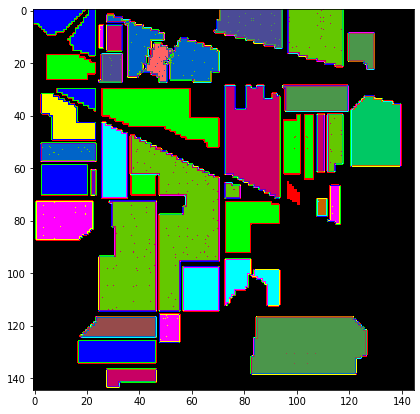

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

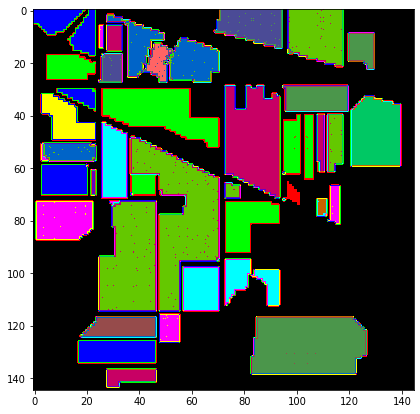

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)

In [ ]:
img = cv2.imread('predictions.jpg')

In [ ]:
print('Image dimensions:', img.shape)

Image dimensions: (145, 145, 3)


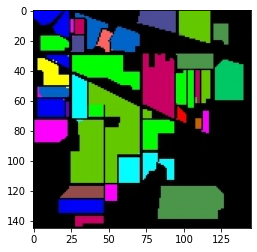

In [ ]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

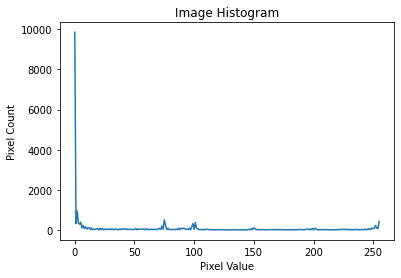

In [ ]:
hist = cv2.calcHist([img], [0], None, [256], [0, 256])
plt.plot(hist)
plt.title('Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Pixel Count')
plt.show()


In [ ]:
print('Minimum pixel value:', np.min(img))
print('Maximum pixel value:', np.max(img))
print('Mean pixel value:', np.mean(img))
print('Standard deviation of pixel values:', np.std(img))

Minimum pixel value: 0
Maximum pixel value: 255
Mean pixel value: 54.295108997225526
Standard deviation of pixel values: 80.9172023736009


In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


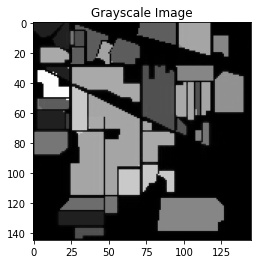

In [ ]:
plt.imshow(gray, cmap='gray')
plt.title('Grayscale Image')
plt.show()


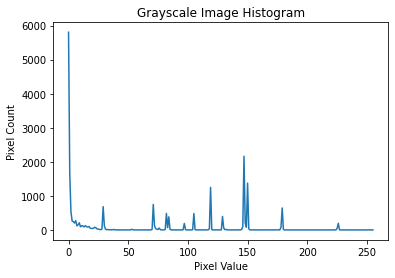

In [ ]:
hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
plt.plot(hist)
plt.title('Grayscale Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Pixel Count')
plt.show()

In [ ]:

# Compute and print image statistics
print('Minimum pixel value:', np.min(gray))
print('Maximum pixel value:', np.max(gray))
print('Mean pixel value:', np.mean(gray))
print('Standard deviation of pixel values:', np.std(gray))

Minimum pixel value: 0
Maximum pixel value: 227
Mean pixel value: 60.562901307966705
Standard deviation of pixel values: 66.38998859494637


In [ ]:
# Threshold the grayscale image
ret, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

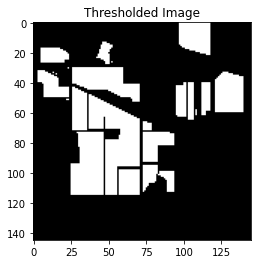

In [ ]:
# Show thresholded image
plt.imshow(thresh, cmap='gray')
plt.title('Thresholded Image')
plt.show()


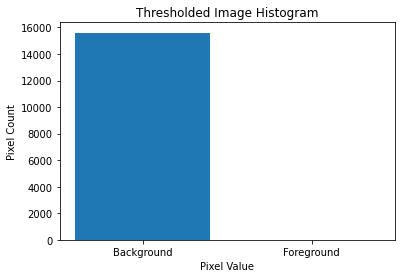

In [ ]:
# Compute and plot thresholded image histogram
hist = cv2.calcHist([thresh], [0], None, [2], [0, 2])
plt.bar([0, 1], hist.ravel())
plt.xticks([0, 1], ['Background', 'Foreground'])
plt.title('Thresholded Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Pixel Count')
plt.show()

In [ ]:
# Apply edge detection to the grayscale image
edges = cv2.Canny(gray, 100, 200)

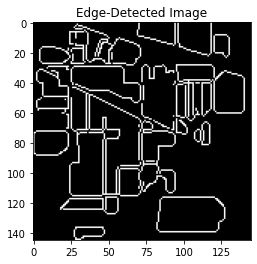

In [ ]:
# Show edge-detected image
plt.imshow(edges, cmap='gray')
plt.title('Edge-Detected Image')
plt.show()

In [ ]:
# Load the ground truth image
img = Image.open("predictions.jpg")

In [ ]:
# Convert the image to a NumPy array
img_arr = np.array(img)
print(img_arr)

[[[  0   1 254]
  [  0   1 254]
  [  0   1 254]
  ...
  [  0   0   0]
  [  0   0   2]
  [  0   0   0]]

 [[  2   2 240]
  [  1   2 243]
  [  0   1 251]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  2   1 242]
  [  2   1 242]
  [  1   1 247]
  ...
  [  0   0   0]
  [  0   1   0]
  [  0   0   0]]

 ...

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


In [ ]:
# Determine the number of pixels in the image
num_pixels = img_arr.shape[0] * img_arr.shape[1]

In [ ]:
# Count the number of pixels for each color
color_counts = {}
for row in img_arr:
    for pixel in row:
        if tuple(pixel) in color_counts:
            color_counts[tuple(pixel)] += 1
        else:
            color_counts[tuple(pixel)] = 1

In [ ]:
# Calculate the percentage of pixels for each color
color_percents = {}
for color, count in color_counts.items():
    color_percents[color] = count / num_pixels * 100

In [ ]:
# Print the results
for color, percent in color_percents.items():
  if percent > 0.1:
    print("Color {}: {:.2f}%".format(color, percent))

Color (0, 1, 254): 0.30%
Color (0, 0, 254): 0.19%
Color (0, 2, 254): 0.25%
Color (4, 0, 4): 0.50%
Color (1, 1, 0): 0.21%
Color (0, 0, 2): 0.78%
Color (1, 0, 0): 1.47%
Color (3, 0, 0): 0.60%
Color (6, 0, 0): 0.25%
Color (0, 0, 0): 21.34%
Color (0, 1, 2): 0.18%
Color (3, 0, 2): 0.30%
Color (1, 0, 2): 0.65%
Color (0, 1, 0): 2.26%
Color (0, 0, 4): 0.22%
Color (0, 1, 4): 0.15%
Color (76, 75, 151): 0.14%
Color (76, 76, 148): 0.15%
Color (76, 76, 150): 0.14%
Color (0, 11, 0): 0.51%
Color (101, 198, 3): 0.59%
Color (104, 195, 12): 0.22%
Color (99, 200, 0): 1.95%
Color (95, 204, 0): 0.43%
Color (102, 197, 9): 0.21%
Color (99, 199, 2): 0.28%
Color (97, 203, 0): 0.59%
Color (98, 201, 0): 0.45%
Color (101, 198, 5): 0.28%
Color (98, 202, 0): 0.56%
Color (102, 197, 7): 0.29%
Color (0, 13, 0): 0.13%
Color (0, 4, 0): 0.76%
Color (0, 2, 0): 0.97%
Color (7, 0, 0): 0.20%
Color (8, 0, 0): 0.19%
Color (10, 0, 0): 0.14%
Color (0, 0, 5): 0.22%
Color (116, 181, 51): 0.19%
Color (94, 206, 0): 0.26%
Color (3, 0

In [ ]:
# Flatten the array to a list of RGB values
data = img_arr.reshape(-1, 3)
print(data)

[[  0   1 254]
 [  0   1 254]
 [  0   1 254]
 ...
 [  0   0   0]
 [  0   0   0]
 [  0   0   0]]


In [ ]:
# Apply k-means clustering with k=3 (can adjust as needed)
kmeans = KMeans(n_clusters=17).fit(data)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
# Replace each pixel with its cluster center
new_data = kmeans.cluster_centers_[kmeans.labels_]

In [ ]:
# Reshape the data back into the original image shape
new_img_arr = new_data.reshape(img_arr.shape).astype(np.uint8)

In [ ]:
# Create a new image from the processed array
new_img = Image.fromarray(new_img_arr)

In [ ]:
# Save the new image
new_img.save("merged_colors.png")

In [ ]:
# Load the Clustered Image
cimg = Image.open("merged_colors.png")

In [ ]:
# Convert the image to a NumPy array
img_arr = np.array(cimg)
print(img_arr)


[[[  1   2 249]
  [  1   2 249]
  [  1   2 249]
  ...
  [  1   2   1]
  [  1   2   1]
  [  1   2   1]]

 [[  1   2 249]
  [  1   2 249]
  [  1   2 249]
  ...
  [  1   2   1]
  [  1   2   1]
  [  1   2   1]]

 [[  1   2 249]
  [  1   2 249]
  [  1   2 249]
  ...
  [  1   2   1]
  [  1   2   1]
  [  1   2   1]]

 ...

 [[  1   2   1]
  [  1   2   1]
  [  1   2   1]
  ...
  [  1   2   1]
  [  1   2   1]
  [  1   2   1]]

 [[  1   2   1]
  [  1   2   1]
  [  1   2   1]
  ...
  [  1   2   1]
  [  1   2   1]
  [  1   2   1]]

 [[  1   2   1]
  [  1   2   1]
  [  1   2   1]
  ...
  [  1   2   1]
  [  1   2   1]
  [  1   2   1]]]


In [ ]:
# Determine the number of pixels in the image
num_pixels = img_arr.shape[0] * img_arr.shape[1]

In [ ]:
# Count the number of pixels for each color
color_counts = {}
for row in img_arr:
    for pixel in row:
        if tuple(pixel) in color_counts:
            color_counts[tuple(pixel)] += 1
        else:
            color_counts[tuple(pixel)] = 1

In [ ]:

# Calculate the percentage of pixels for each color
color_percents = {}
for color, count in color_counts.items():
    color_percents[color] = count / num_pixels * 100


In [ ]:
color_dict = {
    'Blue - Soybean-clean': (1, 2, 249),
    'Indigo - Corn-mintill': (9, 9, 180),
    'Dark Purple - Oats': (13, 3, 40),
    'Black - Unknown': (1, 2, 1),
    'Slate Grey - Buildings-Grass-Trees-Drives': (76, 73, 148),
    'Lime Green - Soybean-mintill': (100, 198, 6),
    'Royal Blue - Soybean-clean': (6, 99, 195),
    'Crimson - Alfalfa': (198, 5, 95),
    'Brown - Wheat': (150, 73, 68),
    'Magenta - Soybean-notill': (240, 10, 238),
    'Olive Green - Woods': (79, 150, 76),
    'Coral - Stone-Steel-Towers': (240, 109, 106),
    'Green - Corn-notill': (44, 224, 44),
    'Sea Green - Hay-windrowed': (6, 198, 101),
    'Light Green - Soybean-mintill': (3, 252, 3),
    'Yellow - Corn': (252, 251, 17),
    'Cyan - Grass-trees': (17, 247, 247)
}

In [ ]:
# Print the results
for color, count in color_counts.items():
    percent = count / num_pixels * 100
    color_name = None
    for name, rgb in color_dict.items():
        if rgb == color:
            color_name = name
            break
    if color_name is None:
        color_name = "Unknown"
    print("Color {}: {} ({:.2f}%)".format(color, color_name, percent))

Color (1, 2, 249): Blue - Soybean-clean (2.96%)
Color (9, 9, 180): Indigo - Corn-mintill (1.03%)
Color (13, 3, 40): Dark Purple - Oats (3.24%)
Color (1, 2, 1): Black - Unknown (47.95%)
Color (76, 73, 148): Slate Grey - Buildings-Grass-Trees-Drives (2.10%)
Color (100, 198, 6): Lime Green - Soybean-mintill (11.31%)
Color (6, 99, 195): Royal Blue - Soybean-clean (2.63%)
Color (198, 5, 95): Crimson - Alfalfa (4.69%)
Color (150, 73, 68): Brown - Wheat (1.27%)
Color (240, 10, 238): Magenta - Soybean-notill (2.29%)
Color (79, 150, 76): Olive Green - Woods (6.41%)
Color (240, 109, 106): Coral - Stone-Steel-Towers (0.47%)
Color (44, 224, 44): Green - Corn-notill (1.61%)
Color (6, 198, 101): Sea Green - Hay-windrowed (2.25%)
Color (3, 252, 3): Light Green - Soybean-mintill (5.17%)
Color (252, 251, 17): Yellow - Corn (1.13%)
Color (17, 247, 247): Cyan - Grass-trees (3.49%)


In [ ]:
# Data
colors = ['Blue - Soybean-clean', 'Indigo - Corn-mintill', 'Dark Purple - Oats', 'Black - Unknown', 'Slate Grey - Buildings-Grass-Trees-Drives', 'Lime Green - Soybean-mintill', 'Royal Blue - Soybean-clean', 'Crimson - Alfalfa', 'Brown - Wheat', 'Magenta - Soybean-notill', 'Olive Green - Woods', 'Coral - Stone-Steel-Towers', 'Green - Corn-notill', 'Sea Green - Hay-windrowed', 'Light Green - Soybean-mintill', 'Yellow - Corn', 'Cyan - Grass-trees']
percentages = [2.96, 1.04, 3.24, 47.95, 2.10, 11.31, 2.63, 4.69, 1.27, 2.29, 6.41, 0.47, 1.61, 2.25, 5.17, 1.13, 3.49]

<BarContainer object of 17 artists>

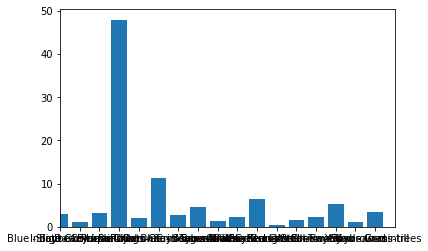

In [ ]:
# Plot
fig, ax = plt.subplots()
plt.xlim([0, 17])  # set the x-axis limits to 0 and 20
ax.bar(colors, percentages)

<ipython-input-83-1286f6a5c912>:4: UserWarning:

FixedFormatter should only be used together with FixedLocator



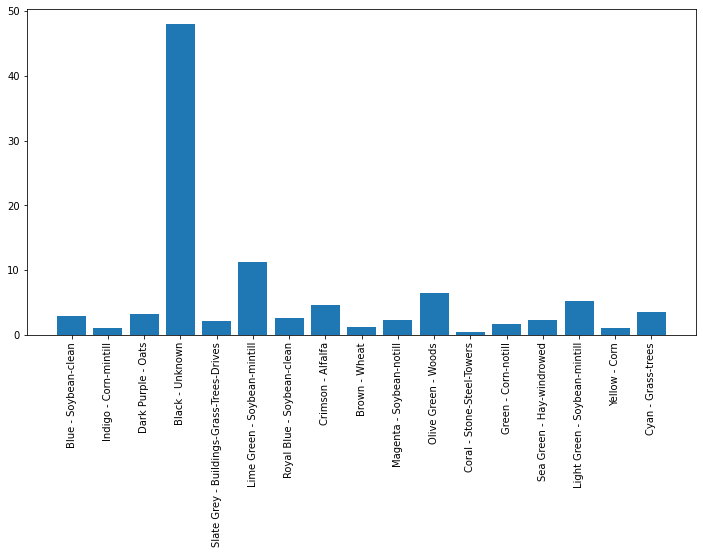

In [ ]:
# Formatting
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(colors, percentages)
ax.set_xticklabels(colors, rotation=90)
plt.show()

In [ ]:
img = Image.open('predictions.jpg')
arr = np.array(img)

In [ ]:
# Define the file name for the Matlab file
mat_file = 'image.mat'


In [ ]:
# Save the array as a Matlab file
savemat(mat_file, {'img': arr})

In [ ]:
img = Image.open('predictions.jpg')
arr = np.array(img)

img_data_2d = np.reshape(arr, img_shape[:2])

plt.imshow(img_data_2d)
plt.show()

NameError: ignored